# Claims Fraud Detection

This notebook generates a synthetic property claims dataset, performs exploratory data analysis, trains a fraud-detection model, and produces interpretability visuals suitable for claims SIU stakeholders.

In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.special import expit
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier
import shap

plt.style.use("seaborn-v0_8")
sns.set_context("talk")

/Users/michaelmcdonogh/Documents/git/MachineLearningCalculateRiskPremium/CascadeProjects/windsurf-project/insurance-ml-demos/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. Generate synthetic claims data

Features mirror common fraud indicators such as prior claim history, claim amount, and suspicious activity scores. The outcome variable represents whether the claim requires special investigations.

In [2]:
rng = np.random.default_rng(42)
n_samples = 2000

claim_amount = rng.normal(7500, 2500, n_samples).clip(500, 25000)
claimant_age = rng.integers(18, 85, n_samples)
num_prior_claims = rng.poisson(1.2, n_samples)
time_since_last_claim = rng.exponential(18, n_samples).clip(0, 120)
suspicious_score = rng.beta(2, 5, n_samples)
policy_tenure = rng.normal(6, 3, n_samples).clip(0.2, 25)
incident_state = rng.choice(["CA", "NY", "FL", "IL", "TX", "OH", "NC"], n_samples, p=[0.2, 0.18, 0.16, 0.12, 0.12, 0.12, 0.1])
channel = rng.choice(["Agent", "Digital", "Call Center"], n_samples, p=[0.55, 0.25, 0.2])

linear = (
    -3.2
    + 0.00025 * claim_amount
    + 0.18 * num_prior_claims
    - 0.015 * time_since_last_claim
    - 0.02 * policy_tenure
    + 1.6 * suspicious_score
    + rng.normal(0, 0.3, n_samples)
)
fraud_probability = expit(linear)
fraudulent = rng.binomial(1, fraud_probability)

claims_df = pd.DataFrame(
    {
        "claim_amount": claim_amount,
        "claimant_age": claimant_age,
        "num_prior_claims": num_prior_claims,
        "time_since_last_claim": time_since_last_claim,
        "policy_tenure_years": policy_tenure,
        "suspicious_score": suspicious_score,
        "incident_state": incident_state,
        "submission_channel": channel,
        "fraudulent": fraudulent,
    }
)

Path("data").mkdir(parents=True, exist_ok=True)
data_path = Path("data/claims_fraud.csv")
claims_df.to_csv(data_path, index=False)
print(f"Synthetic dataset saved to {data_path.resolve()}")
claims_df.head()

Synthetic dataset saved to /Users/michaelmcdonogh/Documents/git/MachineLearningCalculateRiskPremium/CascadeProjects/windsurf-project/insurance-ml-demos/data/claims_fraud.csv


,claim_amount,claimant_age,num_prior_claims,time_since_last_claim,policy_tenure_years,suspicious_score,incident_state,submission_channel,fraudulent
0,8261.792699,67,2,10.887221,11.545390,0.106504,NY,Digital,1
1,4900.039734,20,1,21.552443,11.113141,0.258244,TX,Agent,0
2,9376.127990,42,1,5.235604,6.898776,0.136472,CA,Agent,0
3,9851.411791,47,3,42.671477,5.244064,0.577244,CA,Agent,0
4,2622.412028,82,1,16.891809,3.124684,0.077820,NY,Agent,0


## 2. Exploratory analysis

In [3]:
claims = pd.read_csv("data/claims_fraud.csv")
claims.describe(include="all").transpose().head(10)

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
claim_amount,2000.0,NaN,NaN,NaN,7364.326371,2498.650745,500.0,5700.000792,7443.833662,8998.558492,15447.134198
claimant_age,2000.0,NaN,NaN,NaN,50.6865,19.217072,18.0,34.75,51.0,67.25,84.0
num_prior_claims,2000.0,NaN,NaN,NaN,1.1565,1.059986,0.0,0.0,1.0,2.0,6.0
time_since_last_claim,2000.0,NaN,NaN,NaN,17.958602,17.795099,0.007723,5.310661,12.417746,24.560061,120.0
policy_tenure_years,2000.0,NaN,NaN,NaN,6.145481,2.929669,0.2,4.029005,6.173741,8.15118,15.473269
suspicious_score,2000.0,NaN,NaN,NaN,0.280957,0.159789,0.006147,0.157191,0.259658,0.381873,0.878343
incident_state,2000,7,CA,396,NaN,NaN,NaN,NaN,NaN,NaN,NaN
submission_channel,2000,3,Agent,1123,NaN,NaN,NaN,NaN,NaN,NaN,NaN
fraudulent,2000.0,NaN,NaN,NaN,0.2665,0.442239,0.0,0.0,0.0,1.0,1.0


/var/folders/d2/4vnsb4hn5vq5bb7wds771vx80000gn/T/ipykernel_55741/3884565535.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(["Legitimate", "Fraudulent"])


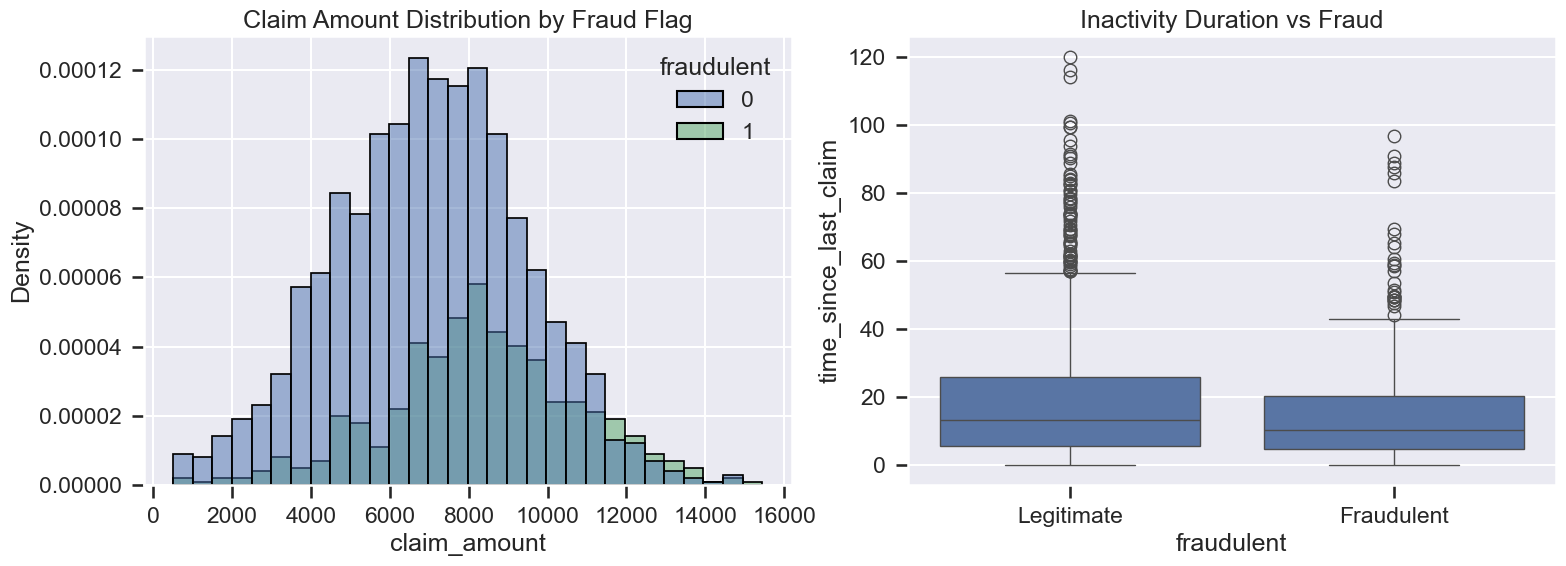

In [4]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
sns.histplot(claims, x="claim_amount", hue="fraudulent", bins=30, stat="density", ax=axes[0])
axes[0].set_title("Claim Amount Distribution by Fraud Flag")
sns.boxplot(data=claims, x="fraudulent", y="time_since_last_claim", ax=axes[1])
axes[1].set_title("Inactivity Duration vs Fraud")
axes[1].set_xticklabels(["Legitimate", "Fraudulent"])
plt.tight_layout()
plt.show()

In [5]:
pd.crosstab(claims["incident_state"], claims["fraudulent"], normalize="index").round(3)

fraudulent,0,1
incident_state,,
CA,0.737,0.263
FL,0.766,0.234
IL,0.753,0.247
NC,0.726,0.274
NY,0.736,0.264
OH,0.718,0.282
TX,0.684,0.316


## 3. Model training and evaluation

In [6]:
features = pd.get_dummies(claims.drop(columns=["fraudulent"]), drop_first=True)
target = claims["fraudulent"]

X_train, X_test, y_train, y_test = train_test_split(
    features, target, test_size=0.25, stratify=target, random_state=42
)

model = RandomForestClassifier(
    n_estimators=300,
    max_depth=8,
    min_samples_split=10,
    random_state=42,
    class_weight="balanced"
)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.77      0.75      0.76       367
           1       0.36      0.38      0.37       133

    accuracy                           0.65       500
   macro avg       0.56      0.57      0.56       500
weighted avg       0.66      0.65      0.66       500



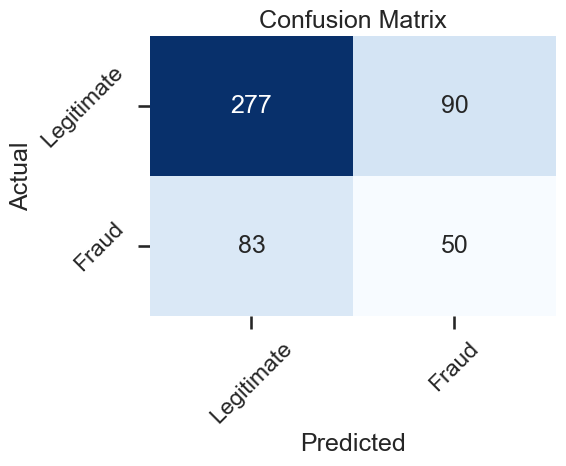

In [7]:
cm = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, ax=ax)
ax.set_xlabel("Predicted")
ax.set_ylabel("Actual")
ax.set_title("Confusion Matrix")
ax.set_xticklabels(["Legitimate", "Fraud"], rotation=45)
ax.set_yticklabels(["Legitimate", "Fraud"], rotation=45)
plt.tight_layout()
plt.show()

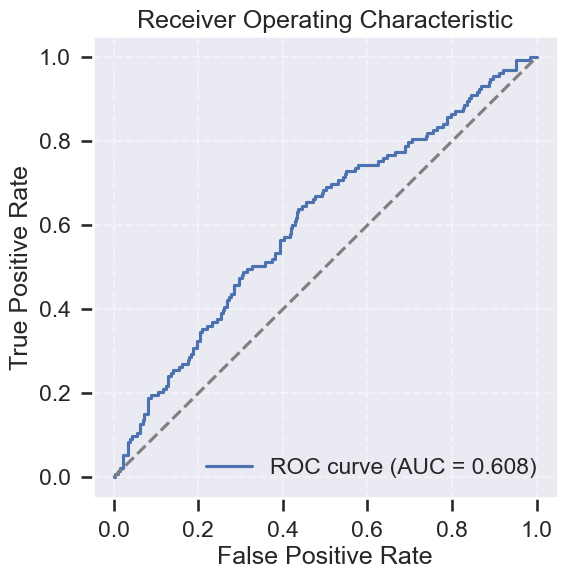

In [8]:
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="grey")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic")
plt.legend(loc="lower right")
plt.grid(True, linestyle='--', alpha=0.4)
plt.show()

## 4. Feature importance with SHAP

/var/folders/d2/4vnsb4hn5vq5bb7wds771vx80000gn/T/ipykernel_55741/2845052743.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importance.values[:15], y=importance.index[:15], orient='h', palette='viridis')


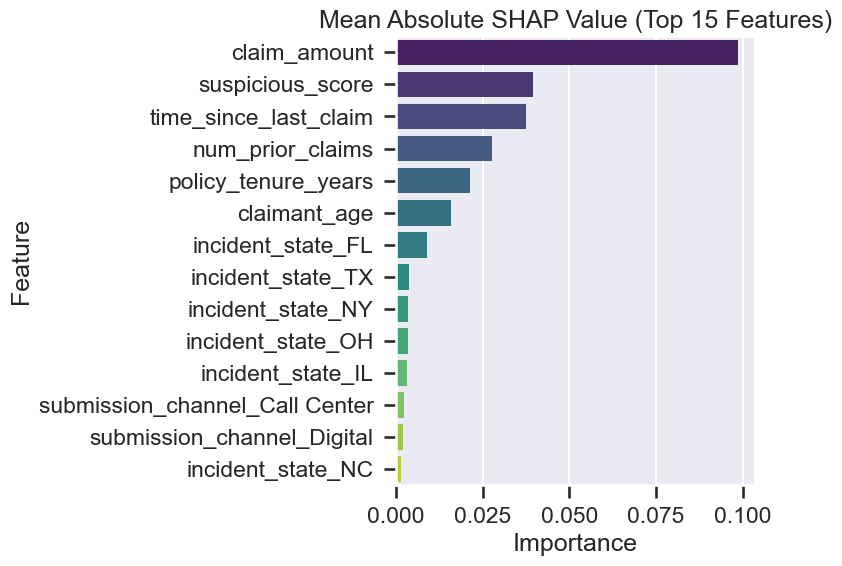

In [9]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)
if isinstance(shap_values, list):
    shap_array = shap_values[1]
else:
    shap_array = shap_values
    if hasattr(shap_array, 'values'):
        shap_array = shap_array.values
if shap_array.ndim == 3:
    shap_array = shap_array[:, :, -1]
importance = (
    pd.Series(np.abs(shap_array).mean(axis=0), index=X_test.columns)
    .sort_values(ascending=False)
)

plt.figure(figsize=(8, 6))
sns.barplot(x=importance.values[:15], y=importance.index[:15], orient='h', palette='viridis')
plt.title('Mean Absolute SHAP Value (Top 15 Features)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()